<a href="https://colab.research.google.com/github/anzzzs/RL_SuttonBarto/blob/main/4_7Jack's_car_rental_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

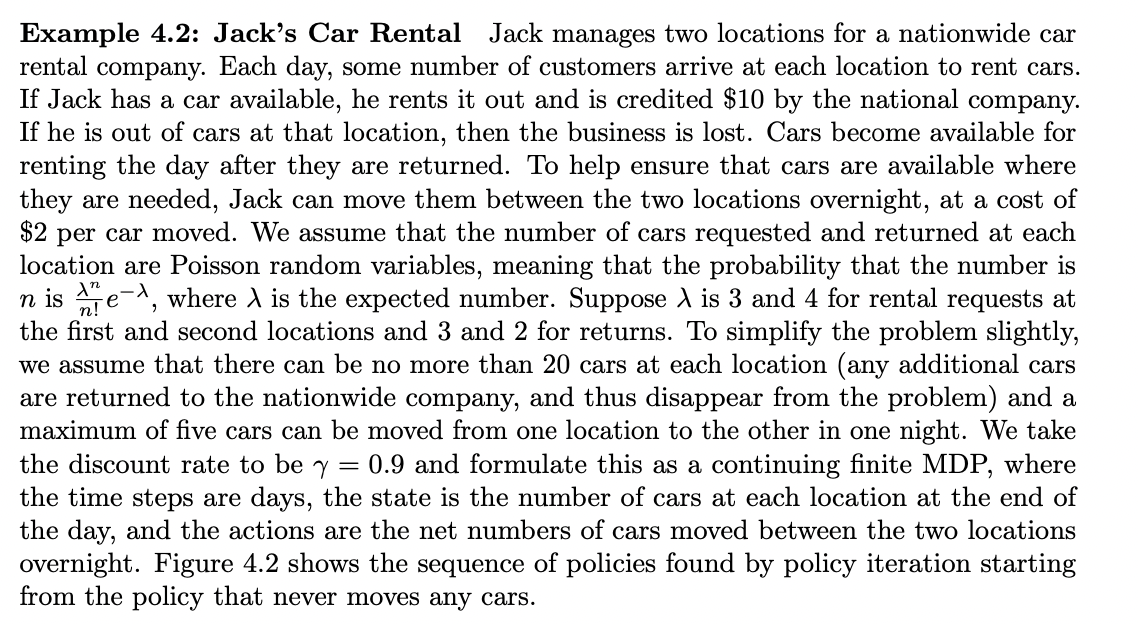

In [ ]:
import numpy as np
import logging
import sys
from typing import List
import warnings
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.stats import poisson

# Using logging
logging.basicConfig(level=logging.WARNING)

In [253]:
class Environment():
  def _get_states_actions_space(self):
    return {
        state:self.get_actions(state)
        for state in self.states_space
    }

  def _get_states_space(self):
    return [
        state
        for state
        in product(range(self.max_cars+1),
                   range(self.max_cars+1))
    ]

  def __init__(self,
               moving_cost:int=2,
               rents_profit:int=10,
               max_cars:int=20,
               max_moved_cars:int=5,
               mean_requests:List[int] = [3,4],
               mean_returns:List[int] = [3,2]):
    self.__moving_cost = moving_cost
    self.__rents_profit = rents_profit
    self.__max_cars = max_cars
    self.__max_moved_cars = max_moved_cars
    self.__mean_requests = mean_requests
    self.__mean_returns = mean_returns

    self.__states_space = self._get_states_space()
    self.__states_actions_space = self._get_states_actions_space()


    self._pmf_returns = [
        poisson.pmf(np.arange(max_cars+1), mean_return)
        for mean_return in mean_returns
        ]
    self._pmf_requests = [
        poisson.pmf(np.arange(max_cars+1), mean_request)
        for mean_request in mean_requests
    ]

    # Lazy storage for (s,a,s') -> p(s'|s,a)
    self._trans_cache = {}
    # Lazy storage for (s,a) -> r(s,a)
    self._rewards_cache = {}

  @property
  def states_actions_space(self):
    return self.__states_actions_space

  @property
  def mean_returns(self):
    return self.__mean_returns

  @property
  def mean_requests(self):
    return self.__mean_requests

  @property
  def states_space(self):
    return self.__states_space

  @property
  def moving_cost(self):
      return self.__moving_cost

  @property
  def rents_profit(self):
      return self.__rents_profit

  @property
  def max_cars(self):
      return self.__max_cars

  @property
  def max_moved_cars(self):
      return self.__max_moved_cars

  def P(self, next_state, current_state, action):
    """Distribution p(s'|s,a)"""
    key = (next_state, current_state, action)
    if key not in self._trans_cache:
        self._trans_cache[key] = self._compute_transition_prob(next_state, current_state, action)
    return self._trans_cache[key]

  def _compute_transition_prob(self, next_state, current_state, action):
    # the action directly affects the state
    s = [current_state[0]+action, current_state[1]-action]

    prob = 1
    for loc_idx in range(2):
      loc_prob = 0
      for ret in range(self.max_cars+1):
        for req in range(self.max_cars+1):
          loc_changed = min(max(s[loc_idx] - req, 0)+ret, self.max_cars)
          if loc_changed == next_state[loc_idx]:
            loc_prob += self._pmf_returns[loc_idx][ret]*self._pmf_requests[loc_idx][req]
      prob *= loc_prob

    return prob

  def get_actions(self, state):
    """
    the idea is to restrict availible action by the next rules:
    1. Jack cannot transport more cars from a location than there are currently in that location.
    2. Jack cannot bring more cars to a location than it can accommodate (self.max_cars_on_location).
    3. Jack cannot move more than self.max_moved_cars cars
    """
    negative_actions = min(state[0], self.max_cars - state[1])

    postive_actions = min(self.max_cars-state[0], state[1])

    actions = [
        action for action
        in range(-1*min(self.max_moved_cars, negative_actions),
                 min(self.max_moved_cars, postive_actions)+1)
    ]
    return actions

  def R(self, state, action):
    """Expected reward r(s, a)"""
    key = (state, action)
    if key not in self._rewards_cache:
      self._rewards_cache[key] = self._compute_expected_reward(state, action)
    return self._rewards_cache[key]

  def _compute_expected_reward(self, state, action):
    s = [state[0]+action, state[1]-action]
    reward = -self.moving_cost*abs(action)
    for loc_idx in range(2):
      for r in range(1, s[loc_idx]+1):
        if r == s[loc_idx]:
          r_prob = 1-sum(self._pmf_requests[loc_idx][:r])
        else:
          r_prob = self._pmf_requests[loc_idx][r]

        reward += r_prob*r*self.rents_profit
    return reward

In [207]:
class Agent():

  def _get_default_policy(self):
    policy = {}
    for state, actions in self.env.states_actions_space.items():
      # probs_action = np.array([1/len(actions)]*len(actions))
      probs_action = np.array([1 if action==0 else 0. for action in actions])
      policy[state] = probs_action
    return policy

  def __init__(self,
               env: Environment,
               min_accuracy: float = 0.1,
               gamma: float = 0.9,
               policy: List[float] = None):
    self.gamma = gamma
    self.min_accuracy = min_accuracy
    self.env = env
    self.policy = policy or self._get_default_policy()
    self.state_values = {state:0 for state in self.env.states_space}
    self._archive_state_values = []
    self._archive_policies = [self.policy]
    self._policy_iteration=0

  def _calc_tweight_state(self, state, action):
    """
    Calculation of sum[s'](p(s'|s, a)*v(s'))
    ~ weighted by probablity of action state_value of the next state (s_prime)
    """
    tweight_state = 0
    for state_prime in self.env.states_space:
      tweight_state += (
          self.env.P(state_prime, state, action)*
          self.state_values[state_prime]
          )
    return tweight_state


  def calc_state_value(self, state):
    """state value v=sum[a](pi(a|s)*(r(s,a)+γ*sum[s'](p(s'|s,a)*v(s'))))"""
    state_value = 0
    actions = self.env.__states_actions_space[state]
    for action_idx, action in enumerate(actions):
      action_prob = self.policy[state][action_idx]
      state_value += action_prob * (
          self.env.R(state, action) +
          self.gamma * (
              self._calc_tweight_state(state, action)
          )
      )
    return state_value


  def policy_evaluation(self):
    while True:
      accuracy = 0
      self._archive_state_values.append(deepcopy(self.state_values))
      for state in tqdm(self.env.states_space):
        cur_state_value = self.state_values[state]
        next_state_value = self.calc_state_value(state)
        accuracy = max(accuracy, abs(cur_state_value-next_state_value))
        self.state_values[state] = next_state_value
      print(f"Current accuracy = {accuracy}")
      if accuracy < self.min_accuracy:
        break

  def calc_greedy_action(self, state):
    max_action_idx = 0
    max_q_value = 0
    max_action = 0
    actions = self.env.states_actions_space[state]
    for action_idx, action in enumerate(actions):
      q_value = (self.env.R(state, action)
                +self.gamma
                *self._calc_tweight_state(state, action))
      if q_value > max_q_value:
        max_q_value = q_value
        max_action_idx = action_idx
        max_action = action


    greedy_action = np.zeros(len(actions))
    greedy_action[max_action_idx] = 1.
    return greedy_action

  def policy_control(self):
    policy_stable = True
    for state in self.env.states_space:
      old_action = self.policy[state]
      greedy_action = self.calc_greedy_action(state)
      if not np.array_equal(greedy_action, old_action):
        policy_stable = False
      self.policy[state] = deepcopy(greedy_action)
    return policy_stable

  def draw_matrix_policy(self, policy, title):
    wide_space = self.env.states_actions_space
    matrix_to_draw = np.zeros((self.env.max_cars+1, self.env.max_cars+1))
    for state in wide_space.keys():
      for probs, action in zip(policy[state], wide_space[state]):
        matrix_to_draw[state[0]][state[1]] += probs*action
    plt.imshow(matrix_to_draw,origin='lower')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.show()

  def policy_iteration(self):
    self.draw_matrix_policy(self.policy, f"Policy №{self._policy_iteration}")
    self.policy_evaluation()
    policy_stable = self.policy_control()
    self._policy_iteration += 1
    self._archive_policies.append(deepcopy(self.policy))
    if policy_stable:
      print("Optimal policy was found!")
    else:
      print("We need to accurate current state values..")
      self.policy_iteration()

In [208]:
car_rental = Environment()

In [209]:
agent1 = Agent(car_rental)

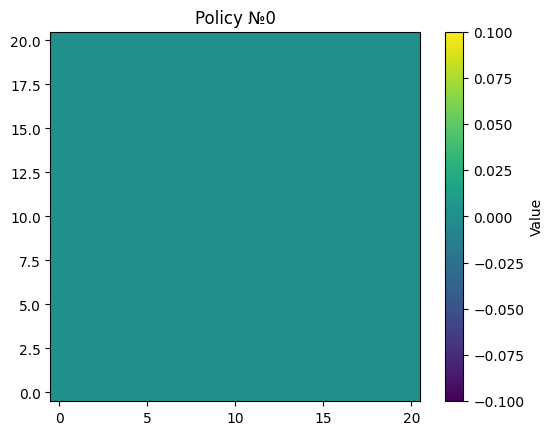

100%|██████████| 441/441 [00:01<00:00, 435.55it/s]


Current accuracy = 193.3490489242185


100%|██████████| 441/441 [00:01<00:00, 359.03it/s]


Current accuracy = 134.0042603704265


100%|██████████| 441/441 [00:01<00:00, 410.42it/s]


Current accuracy = 90.4524371210868


100%|██████████| 441/441 [00:01<00:00, 429.72it/s]


Current accuracy = 67.59779063760405


100%|██████████| 441/441 [00:01<00:00, 337.26it/s]


Current accuracy = 53.584930111353174


100%|██████████| 441/441 [00:01<00:00, 284.15it/s]


Current accuracy = 41.72086236491373


100%|██████████| 441/441 [00:01<00:00, 406.34it/s]


Current accuracy = 32.720108837912335


100%|██████████| 441/441 [00:01<00:00, 429.93it/s]


Current accuracy = 26.08755558601422


100%|██████████| 441/441 [00:01<00:00, 341.92it/s]


Current accuracy = 21.778142862806703


100%|██████████| 441/441 [00:01<00:00, 334.63it/s]


Current accuracy = 18.318059283797652


100%|██████████| 441/441 [00:01<00:00, 335.35it/s]


Current accuracy = 15.367405871343749


100%|██████████| 441/441 [00:01<00:00, 407.98it/s]


Current accuracy = 12.861026681606461


100%|██████████| 441/441 [00:01<00:00, 434.87it/s]


Current accuracy = 10.739286285274147


100%|██████████| 441/441 [00:01<00:00, 299.17it/s]


Current accuracy = 8.94900377676106


100%|██████████| 441/441 [00:01<00:00, 271.36it/s]


Current accuracy = 7.44312810166997


100%|██████████| 441/441 [00:01<00:00, 336.52it/s]


Current accuracy = 6.180205968979294


100%|██████████| 441/441 [00:01<00:00, 340.06it/s]


Current accuracy = 5.123897028048418


100%|██████████| 441/441 [00:01<00:00, 338.58it/s]


Current accuracy = 4.242540113764335


100%|██████████| 441/441 [00:01<00:00, 331.78it/s]


Current accuracy = 3.5087366629765597


100%|██████████| 441/441 [00:01<00:00, 345.33it/s]


Current accuracy = 2.8989343755590085


100%|██████████| 441/441 [00:01<00:00, 399.71it/s]


Current accuracy = 2.3930118871784316


100%|██████████| 441/441 [00:01<00:00, 329.12it/s]


Current accuracy = 1.9738734432806382


100%|██████████| 441/441 [00:01<00:00, 274.59it/s]


Current accuracy = 1.6270637138202346


100%|██████████| 441/441 [00:01<00:00, 408.39it/s]


Current accuracy = 1.3404106986391184


100%|██████████| 441/441 [00:01<00:00, 333.15it/s]


Current accuracy = 1.103701575739251


100%|██████████| 441/441 [00:01<00:00, 326.61it/s]


Current accuracy = 0.908393505451329


100%|██████████| 441/441 [00:01<00:00, 334.58it/s]


Current accuracy = 0.7473592260542432


100%|██████████| 441/441 [00:01<00:00, 337.58it/s]


Current accuracy = 0.6146657957377784


100%|██████████| 441/441 [00:01<00:00, 331.33it/s]


Current accuracy = 0.5053839422160422


100%|██████████| 441/441 [00:01<00:00, 327.13it/s]


Current accuracy = 0.4154250305343794


100%|██████████| 441/441 [00:01<00:00, 376.96it/s]


Current accuracy = 0.34140251871917826


100%|██████████| 441/441 [00:01<00:00, 318.61it/s]


Current accuracy = 0.2805148327457232


100%|██████████| 441/441 [00:01<00:00, 365.58it/s]


Current accuracy = 0.23044677706201355


100%|██████████| 441/441 [00:01<00:00, 418.68it/s]


Current accuracy = 0.18928684812806296


100%|██████████| 441/441 [00:01<00:00, 436.05it/s]


Current accuracy = 0.15545809768065055


100%|██████████| 441/441 [00:01<00:00, 430.00it/s]


Current accuracy = 0.1276604750696606


100%|██████████| 441/441 [00:01<00:00, 423.86it/s]


Current accuracy = 0.10482284871608272


100%|██████████| 441/441 [00:01<00:00, 347.53it/s]


Current accuracy = 0.0860631569436805
We need to accurate current state values..


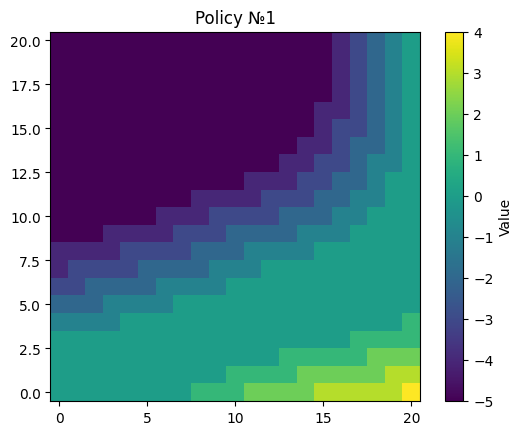

100%|██████████| 441/441 [00:01<00:00, 430.47it/s]


Current accuracy = 64.5759523982415


100%|██████████| 441/441 [00:01<00:00, 359.30it/s]


Current accuracy = 4.872618825442146


100%|██████████| 441/441 [00:01<00:00, 341.38it/s]


Current accuracy = 2.166194880435569


100%|██████████| 441/441 [00:01<00:00, 428.59it/s]


Current accuracy = 1.5734951279687266


100%|██████████| 441/441 [00:01<00:00, 424.44it/s]


Current accuracy = 1.3649912319652344


100%|██████████| 441/441 [00:01<00:00, 426.03it/s]


Current accuracy = 1.1331455168102593


100%|██████████| 441/441 [00:01<00:00, 421.06it/s]


Current accuracy = 0.9302166319875482


100%|██████████| 441/441 [00:01<00:00, 414.32it/s]


Current accuracy = 0.7619361550778194


100%|██████████| 441/441 [00:01<00:00, 423.68it/s]


Current accuracy = 0.6237889009202036


100%|██████████| 441/441 [00:01<00:00, 428.36it/s]


Current accuracy = 0.5106062471988366


100%|██████████| 441/441 [00:01<00:00, 428.85it/s]


Current accuracy = 0.41793069517581216


100%|██████████| 441/441 [00:01<00:00, 411.99it/s]


Current accuracy = 0.34206452908597385


100%|██████████| 441/441 [00:01<00:00, 286.21it/s]


Current accuracy = 0.27996550217324057


100%|██████████| 441/441 [00:01<00:00, 428.67it/s]


Current accuracy = 0.22913793027976226


100%|██████████| 441/441 [00:01<00:00, 365.84it/s]


Current accuracy = 0.18753704483549427


100%|██████████| 441/441 [00:01<00:00, 338.05it/s]


Current accuracy = 0.15348843224950315


100%|██████████| 441/441 [00:01<00:00, 415.84it/s]


Current accuracy = 0.12562129085455354


100%|██████████| 441/441 [00:01<00:00, 350.83it/s]


Current accuracy = 0.10281351304530517


100%|██████████| 441/441 [00:01<00:00, 393.26it/s]


Current accuracy = 0.08414662540985773
We need to accurate current state values..


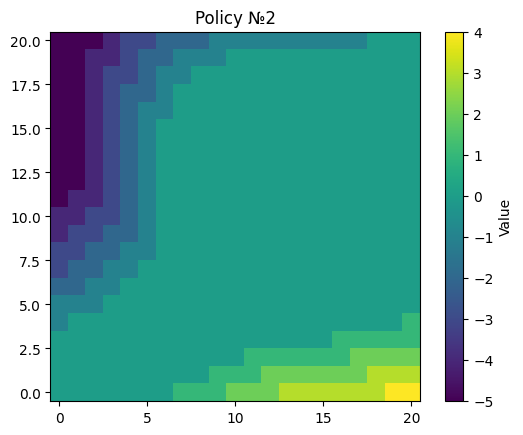

100%|██████████| 441/441 [00:01<00:00, 329.69it/s]


Current accuracy = 4.276330055942367


100%|██████████| 441/441 [00:01<00:00, 292.76it/s]


Current accuracy = 2.844084463243348


100%|██████████| 441/441 [00:01<00:00, 425.39it/s]


Current accuracy = 1.9593361312097386


100%|██████████| 441/441 [00:01<00:00, 347.12it/s]


Current accuracy = 1.415796633943046


100%|██████████| 441/441 [00:01<00:00, 327.90it/s]


Current accuracy = 0.9785748436886479


100%|██████████| 441/441 [00:01<00:00, 360.96it/s]


Current accuracy = 0.658218166115148


100%|██████████| 441/441 [00:01<00:00, 427.03it/s]


Current accuracy = 0.441669128176045


100%|██████████| 441/441 [00:01<00:00, 376.54it/s]


Current accuracy = 0.30159234217785524


100%|██████████| 441/441 [00:01<00:00, 332.56it/s]


Current accuracy = 0.22406240490886375


100%|██████████| 441/441 [00:01<00:00, 322.07it/s]


Current accuracy = 0.17197218026944938


100%|██████████| 441/441 [00:01<00:00, 273.34it/s]


Current accuracy = 0.13659430865419608


100%|██████████| 441/441 [00:01<00:00, 419.46it/s]


Current accuracy = 0.11222811591164827


100%|██████████| 441/441 [00:01<00:00, 421.87it/s]


Current accuracy = 0.09209736075632691
We need to accurate current state values..


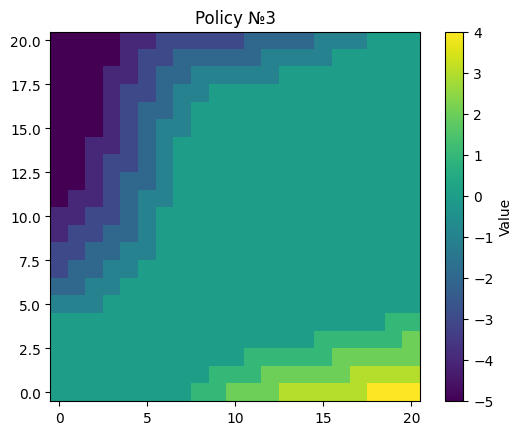

100%|██████████| 441/441 [00:01<00:00, 367.90it/s]


Current accuracy = 0.5438356891108924


100%|██████████| 441/441 [00:01<00:00, 423.26it/s]


Current accuracy = 0.19512004859791432


100%|██████████| 441/441 [00:01<00:00, 416.16it/s]


Current accuracy = 0.10684838621818926


100%|██████████| 441/441 [00:01<00:00, 419.36it/s]


Current accuracy = 0.07076254464027443
We need to accurate current state values..


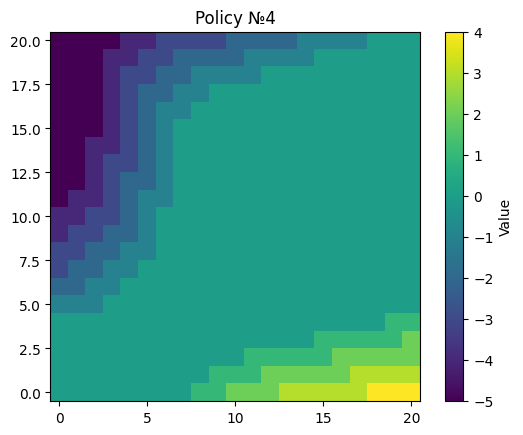

100%|██████████| 441/441 [00:01<00:00, 285.78it/s]


Current accuracy = 0.07720041227605634
Optimal policy was found!


In [210]:
agent1.policy_iteration()

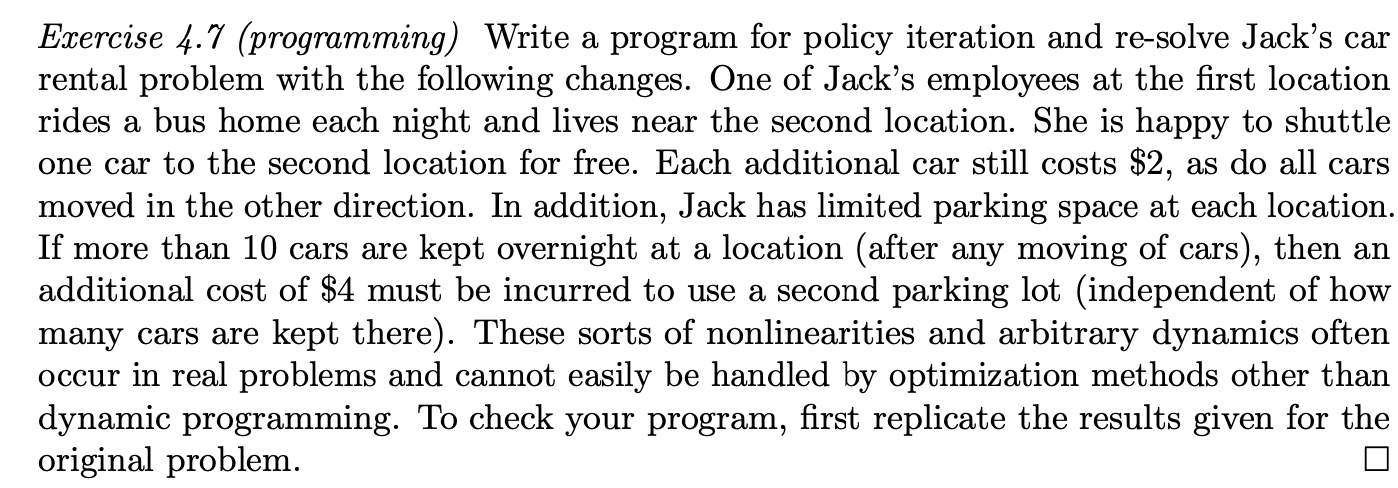

In [261]:
class Environment2(Environment):
  def __init__(self,
               free_moves_in2:int = 1,
               park_limit:int = 10,
               park_cost:int = 4,
               *args,
               **kwargs
               ):
    self._free_moves_in2 = free_moves_in2
    self._park_limit = park_limit
    self._park_cost = park_cost
    super().__init__(*args, **kwargs)

  @property
  def free_moves_in2(self):
    return self._free_moves_in2

  @property
  def park_limit(self):
    return self._park_limit

  @property
  def park_cost(self):
    return self._park_cost

  def _compute_expected_reward(self, state, action):
    s = [state[0]+action, state[1]-action]
    # if cars moves from loc to loc2 ->
    # -> self.free_moves_in2 car is free
    free_car = 0 if action>=0 else self.free_moves_in2
    moved_cars = max(0, abs(action) - free_car)
    parking_cars = sum(map(lambda x: 1 if self.park_limit-x<0 else 0, s))
    reward = -self.park_cost*parking_cars-self.moving_cost*moved_cars
    for loc_idx in range(2):
      for r in range(1, s[loc_idx]+1):
        if r == s[loc_idx]:
          r_prob = 1-sum(self._pmf_requests[loc_idx][:r])
        else:
          r_prob = self._pmf_requests[loc_idx][r]

        reward += r_prob*r*self.rents_profit
    return reward

In [262]:
car_rental2 = Environment2()

In [263]:
agent2 = Agent(car_rental2)

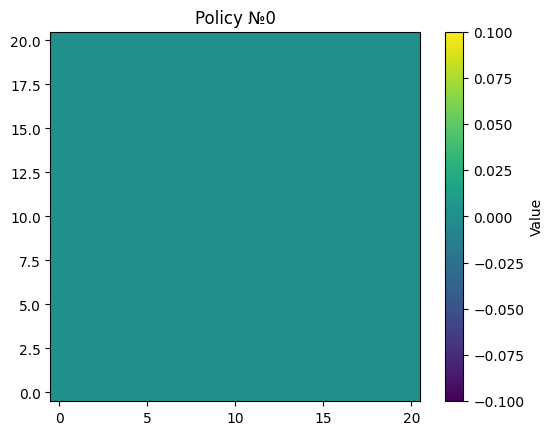

100%|██████████| 441/441 [06:36<00:00,  1.11it/s]


Current accuracy = 172.60825745293968


100%|██████████| 441/441 [00:01<00:00, 348.58it/s]


Current accuracy = 120.86733102694146


100%|██████████| 441/441 [00:01<00:00, 405.88it/s]


Current accuracy = 82.77860370081532


100%|██████████| 441/441 [00:01<00:00, 340.98it/s]


Current accuracy = 65.22547642911132


100%|██████████| 441/441 [00:01<00:00, 343.26it/s]


Current accuracy = 52.09847323802407


100%|██████████| 441/441 [00:01<00:00, 402.84it/s]


Current accuracy = 40.67176210305422


100%|██████████| 441/441 [00:01<00:00, 386.22it/s]


Current accuracy = 31.88620400727916


100%|██████████| 441/441 [00:01<00:00, 434.64it/s]


Current accuracy = 25.37460212059932


100%|██████████| 441/441 [00:01<00:00, 383.21it/s]


Current accuracy = 21.205739674591428


100%|██████████| 441/441 [00:00<00:00, 446.47it/s]


Current accuracy = 17.771297898065825


100%|██████████| 441/441 [00:01<00:00, 371.35it/s]


Current accuracy = 14.861553025463536


100%|██████████| 441/441 [00:01<00:00, 297.31it/s]


Current accuracy = 12.403819228610246


100%|██████████| 441/441 [00:01<00:00, 410.50it/s]


Current accuracy = 10.33328921585678


100%|██████████| 441/441 [00:01<00:00, 407.62it/s]


Current accuracy = 8.593402138149315


100%|██████████| 441/441 [00:01<00:00, 411.77it/s]


Current accuracy = 7.135037749982985


100%|██████████| 441/441 [00:00<00:00, 449.89it/s]


Current accuracy = 5.915602438569749


100%|██████████| 441/441 [00:00<00:00, 462.85it/s]


Current accuracy = 4.898251062104293


100%|██████████| 441/441 [00:01<00:00, 402.78it/s]


Current accuracy = 4.051234713561485


100%|██████████| 441/441 [00:01<00:00, 351.62it/s]


Current accuracy = 3.3473264254390074


100%|██████████| 441/441 [00:01<00:00, 356.22it/s]


Current accuracy = 2.7632944451182198


100%|██████████| 441/441 [00:00<00:00, 480.43it/s]


Current accuracy = 2.2794120270957023


100%|██████████| 441/441 [00:01<00:00, 286.40it/s]


Current accuracy = 1.8790030387329466


100%|██████████| 441/441 [00:00<00:00, 459.10it/s]


Current accuracy = 1.5480259771990745


100%|██████████| 441/441 [00:00<00:00, 464.88it/s]


Current accuracy = 1.2746986990769074


100%|██████████| 441/441 [00:00<00:00, 464.24it/s]


Current accuracy = 1.049164602828057


100%|██████████| 441/441 [00:00<00:00, 448.26it/s]


Current accuracy = 0.8631993491474077


100%|██████████| 441/441 [00:00<00:00, 464.41it/s]


Current accuracy = 0.7099559093784364


100%|██████████| 441/441 [00:00<00:00, 463.91it/s]


Current accuracy = 0.5837448933095288


100%|██████████| 441/441 [00:00<00:00, 471.92it/s]


Current accuracy = 0.47984667287101956


100%|██████████| 441/441 [00:00<00:00, 467.62it/s]


Current accuracy = 0.3943516902203328


100%|██████████| 441/441 [00:00<00:00, 468.22it/s]


Current accuracy = 0.3240254219544454


100%|██████████| 441/441 [00:01<00:00, 369.69it/s]


Current accuracy = 0.2661946864589595


100%|██████████| 441/441 [00:01<00:00, 321.70it/s]


Current accuracy = 0.21865226960613882


100%|██████████| 441/441 [00:01<00:00, 367.15it/s]


Current accuracy = 0.17957716363099507


100%|██████████| 441/441 [00:01<00:00, 414.84it/s]


Current accuracy = 0.14746803753797622


100%|██████████| 441/441 [00:01<00:00, 418.59it/s]


Current accuracy = 0.12108786752457945


100%|██████████| 441/441 [00:00<00:00, 469.57it/s]


Current accuracy = 0.09941794302267226
We need to accurate current state values..


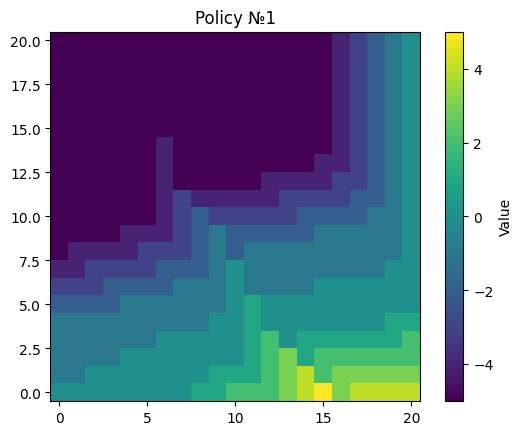

100%|██████████| 441/441 [00:01<00:00, 400.92it/s]


Current accuracy = 89.18535170302533


100%|██████████| 441/441 [00:01<00:00, 358.92it/s]


Current accuracy = 9.114771972788844


100%|██████████| 441/441 [00:01<00:00, 363.10it/s]


Current accuracy = 4.819684382225091


100%|██████████| 441/441 [00:01<00:00, 374.84it/s]


Current accuracy = 3.4349900893373615


100%|██████████| 441/441 [00:01<00:00, 326.22it/s]


Current accuracy = 2.8796117014320544


100%|██████████| 441/441 [00:01<00:00, 439.41it/s]


Current accuracy = 2.387335422140154


100%|██████████| 441/441 [00:00<00:00, 465.97it/s]


Current accuracy = 1.9628305813908469


100%|██████████| 441/441 [00:00<00:00, 463.06it/s]


Current accuracy = 1.6095915320616427


100%|██████████| 441/441 [00:00<00:00, 463.52it/s]


Current accuracy = 1.3183927553199055


100%|██████████| 441/441 [00:00<00:00, 468.19it/s]


Current accuracy = 1.0792042511653221


100%|██████████| 441/441 [00:01<00:00, 439.98it/s]


Current accuracy = 0.8830989634444677


100%|██████████| 441/441 [00:01<00:00, 387.22it/s]


Current accuracy = 0.7224805365992211


100%|██████████| 441/441 [00:00<00:00, 472.25it/s]


Current accuracy = 0.591003277016739


100%|██████████| 441/441 [00:00<00:00, 466.02it/s]


Current accuracy = 0.48341618962825805


100%|██████████| 441/441 [00:00<00:00, 443.57it/s]


Current accuracy = 0.3953959671248981


100%|██████████| 441/441 [00:01<00:00, 266.84it/s]


Current accuracy = 0.3233928553394776


100%|██████████| 441/441 [00:01<00:00, 428.13it/s]


Current accuracy = 0.26449675231646097


100%|██████████| 441/441 [00:00<00:00, 473.82it/s]


Current accuracy = 0.21632410199032392


100%|██████████| 441/441 [00:00<00:00, 466.94it/s]


Current accuracy = 0.17692368586983775


100%|██████████| 441/441 [00:00<00:00, 477.24it/s]


Current accuracy = 0.14469874141997252


100%|██████████| 441/441 [00:00<00:00, 465.39it/s]


Current accuracy = 0.11834284852346855


100%|██████████| 441/441 [00:00<00:00, 473.79it/s]


Current accuracy = 0.09678728026352701
We need to accurate current state values..


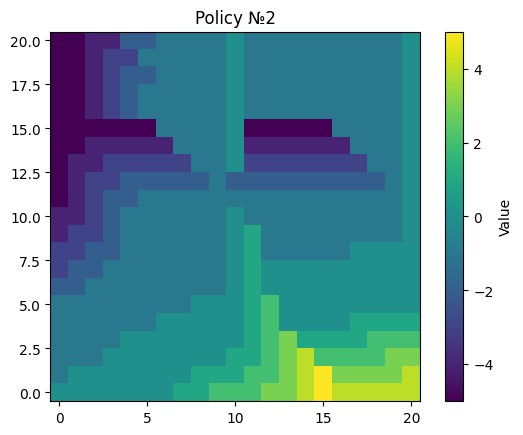

100%|██████████| 441/441 [00:01<00:00, 349.37it/s]


Current accuracy = 11.767029958940498


100%|██████████| 441/441 [00:00<00:00, 449.75it/s]


Current accuracy = 5.971536457727666


100%|██████████| 441/441 [00:00<00:00, 453.33it/s]


Current accuracy = 2.961995852348082


100%|██████████| 441/441 [00:01<00:00, 320.28it/s]


Current accuracy = 1.5859578884113716


100%|██████████| 441/441 [00:00<00:00, 469.83it/s]


Current accuracy = 1.014876339051625


100%|██████████| 441/441 [00:00<00:00, 458.10it/s]


Current accuracy = 0.7050160770941147


100%|██████████| 441/441 [00:00<00:00, 461.53it/s]


Current accuracy = 0.5140802305670604


100%|██████████| 441/441 [00:00<00:00, 465.38it/s]


Current accuracy = 0.3825674671380739


100%|██████████| 441/441 [00:00<00:00, 469.08it/s]


Current accuracy = 0.2923081062277788


100%|██████████| 441/441 [00:01<00:00, 383.89it/s]


Current accuracy = 0.22864936309304085


100%|██████████| 441/441 [00:01<00:00, 364.35it/s]


Current accuracy = 0.18782335787994953


100%|██████████| 441/441 [00:00<00:00, 458.25it/s]


Current accuracy = 0.15399851182797875


100%|██████████| 441/441 [00:00<00:00, 465.63it/s]


Current accuracy = 0.12612323280603732


100%|██████████| 441/441 [00:01<00:00, 336.48it/s]


Current accuracy = 0.10322283015290168


100%|██████████| 441/441 [00:01<00:00, 282.45it/s]


Current accuracy = 0.08444468390302973
We need to accurate current state values..


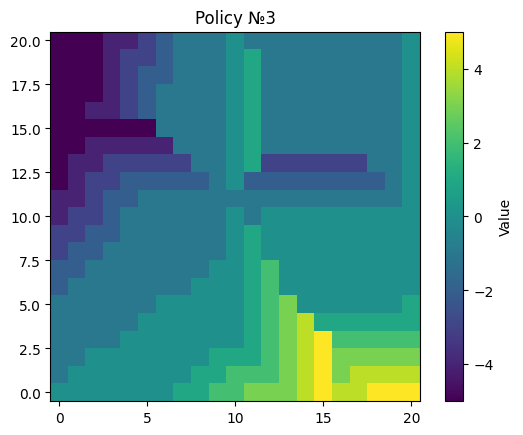

100%|██████████| 441/441 [00:01<00:00, 377.99it/s]


Current accuracy = 3.367720780362447


100%|██████████| 441/441 [00:00<00:00, 466.44it/s]


Current accuracy = 0.41583177662437265


100%|██████████| 441/441 [00:00<00:00, 448.86it/s]


Current accuracy = 0.19461099111754265


100%|██████████| 441/441 [00:01<00:00, 376.65it/s]


Current accuracy = 0.125488747488248


100%|██████████| 441/441 [00:01<00:00, 416.48it/s]


Current accuracy = 0.08190223719350342
Optimal policy was found!


In [264]:
agent2.policy_iteration()